In [42]:
# Librairies
import os
import sys
code_path = os.path.split(os.getcwd())[0]
sys.path.append(code_path)
import numpy as np
from scipy.sparse import load_npz
import seaborn as sns
import pandas as pd
from setting import *
from loader import *
from graphs import *
from utils import *
from plots_and_stats import *
from clustering import *
from XAI_method import *

In [43]:
# Arguments
name = "BRCA"
model_name = 'MLP'
exp = 1
XAI_method = "Integrated_Gradients" # "Expected_Gradients"
set_name = 'train'

In [44]:
# Path
save_path = get_save_path(name, code_path)
save_path = os.path.join(save_path, model_name, f"exp_{exp}", XAI_method)
data_path = get_data_path(name)
create_new_folder(os.path.join(save_path, "figures", set_name))

In [45]:
# Load explanations
X, y_pred, y, class_name, feat_name, baseline, baseline_pred = load_attributions(XAI_method, save_path, set_name=set_name)
feat_name = np.array(feat_name)
# Only correctly classified examples are considered
indices = np.argwhere(y_pred == y).reshape(-1)
X = X[indices]
y = y[indices]

Baseline


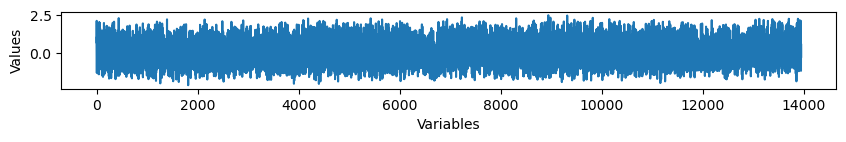

Output of the MLP: [0.0012245652033016086]


In [46]:
# Baseline
print("Baseline")
save_name = os.path.join(save_path, "figures", "baseline")
plot_random_signals(baseline, [0], n_sample_per_class=1, n_variable=baseline.shape[1], save_name=save_name, legend=False)
print(f"Output of the {model_name}: {baseline_pred}")

In [47]:
# Studied classes
base_class, studied_class = get_XAI_hyperparameters(name, n_class)

# Describe dataset

In [48]:
n_class = len(class_name)
print(f"Number of classes: {n_class}\nNumber of variables: {X.shape[1]}\nNumber of samples: {X.shape[0]}")
for c in studied_class:
    print(f"    Class {c} - {np.sum(y==c)}")

Number of classes: 2
Number of variables: 13946
Number of samples: 654
    Class 1 - 654


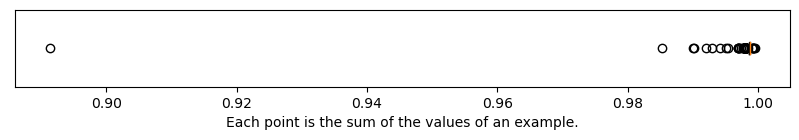

In [49]:
plt.figure(figsize=(10, 1))
plt.boxplot(np.round(np.sum(X, axis=1), 5), vert=False)
plt.yticks([])
plt.xlabel("Each point is the sum of the values of an example.")
plt.show()

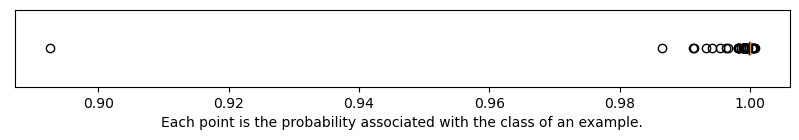

In [50]:
plt.figure(figsize=(10, 1))
if n_class != 2:
    plt.boxplot(np.round(np.sum(X, axis=1), 5) + np.array(baseline_pred)[y], vert=False)
else:
    plt.boxplot(np.round(np.sum(X, axis=1), 5) + np.array(baseline_pred), vert=False)
plt.yticks([])
plt.xlabel("Each point is the probability associated with the class of an example.")
plt.show()

# Describe data

In [51]:
normalise = True
if normalise:
    X = transform_data(X, transform='divide_by_norm')

Attributions averaged per class without std


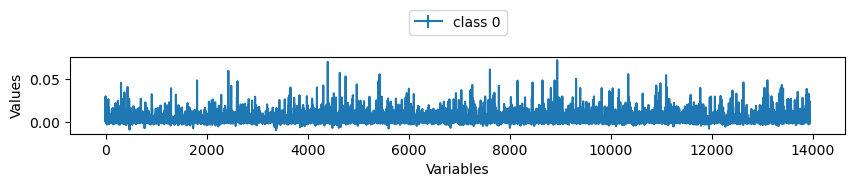

In [52]:
print("Attributions averaged per class without std")
save_name = os.path.join(save_path, "figures", set_name, "average_attributions_without_std")
for c in studied_class:
    plot_average_signals(np.mean(X[y==c, :], axis=0).reshape(1, -1), np.array([0]), n_variable=X.shape[1], save_name=save_name)

Attributions averaged per class with std


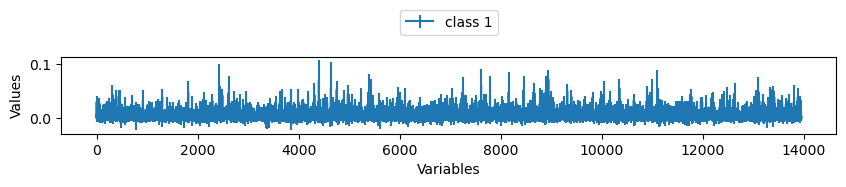

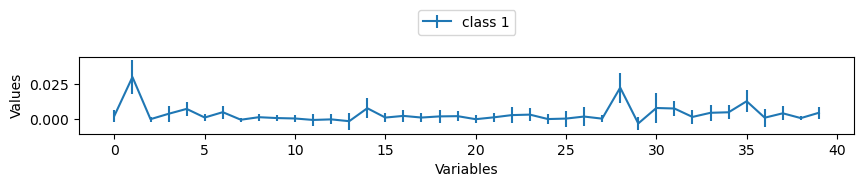

In [53]:
print("Attributions averaged per class with std")
save_name = os.path.join(save_path, "figures", set_name, f"average_attributions")
plot_average_signals(X, y, n_variable=X.shape[1], save_name=save_name)
plot_average_signals(X, y, n_variable=40, save_name=save_name)

Random attributions


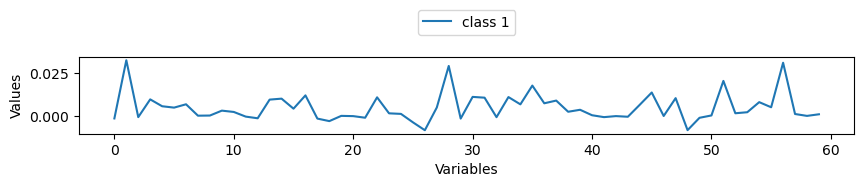

In [54]:
print("Random attributions")
save_name = os.path.join(save_path, "figures", set_name, f"random_attributions")
plot_random_signals(X, y, n_sample_per_class=1, n_variable=60, save_name=save_name)

# Analysis data

### Correlation matrices

In [55]:
method = 'pearson_correlation'
min_value = None

Matrix: pearson_correlation


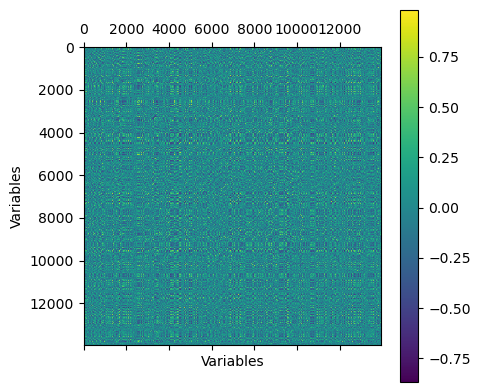

In [56]:
# Between variables
save_name = os.path.join(save_path, "figures", set_name, f"{method}_variables")
print(f"Matrix: {method}")
A = load_npz(os.path.join(save_path, 'graph', f'{set_name}_{method}_{min_value}_variables.npz'))
A = A.toarray()
plot_matrix(A, "Variables", "Variables", save_name)

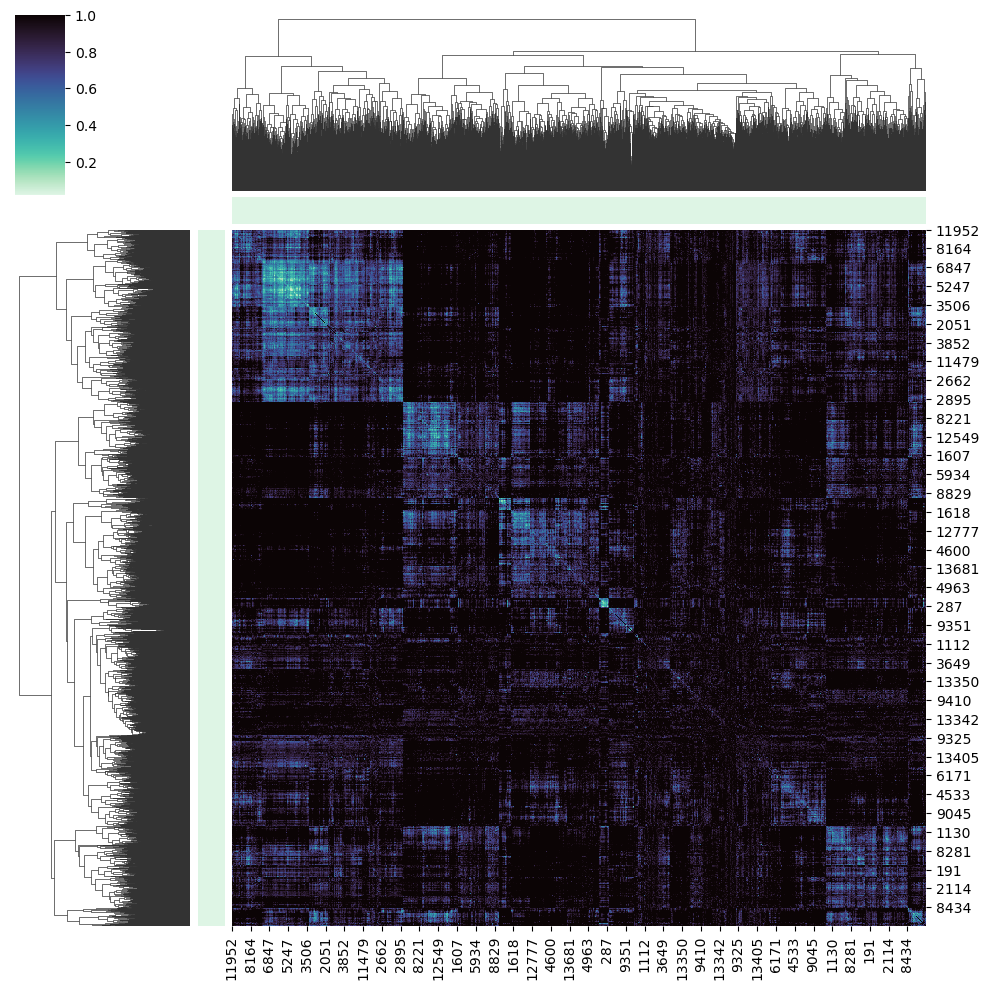

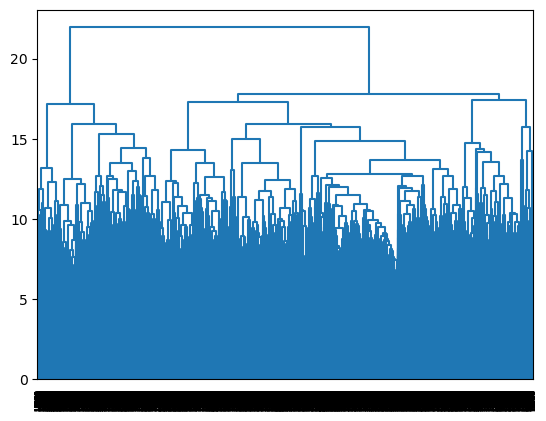

In [60]:
assert np.max(A) <= 1
dist = 1 - (A > 0) * 1. * A
save_name = os.path.join(save_path, "figures", set_name, "cluster_variables")
clusters, colors = cluster_nodes(dist, np.zeros(dist.shape), cut_dendogram=2, vmin=np.min(dist), vmax=np.max(dist), save_path=save_name)

Matrix: pearson_correlation


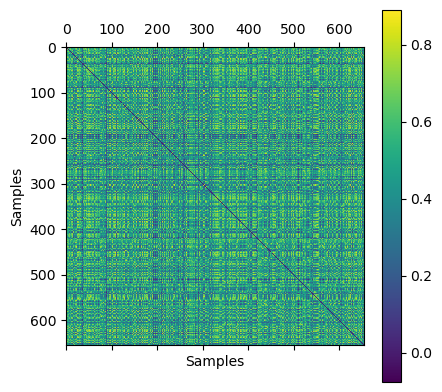

In [61]:
# Between samples
save_name = os.path.join(save_path, "figures", set_name, f"{method}_samples")
print(f"Matrix: {method}")
A = load_npz(os.path.join(save_path, 'graph', f'{set_name}_{method}_{min_value}_samples.npz'))
A = A.toarray()
plot_matrix(A, "Samples", "Samples", save_name)

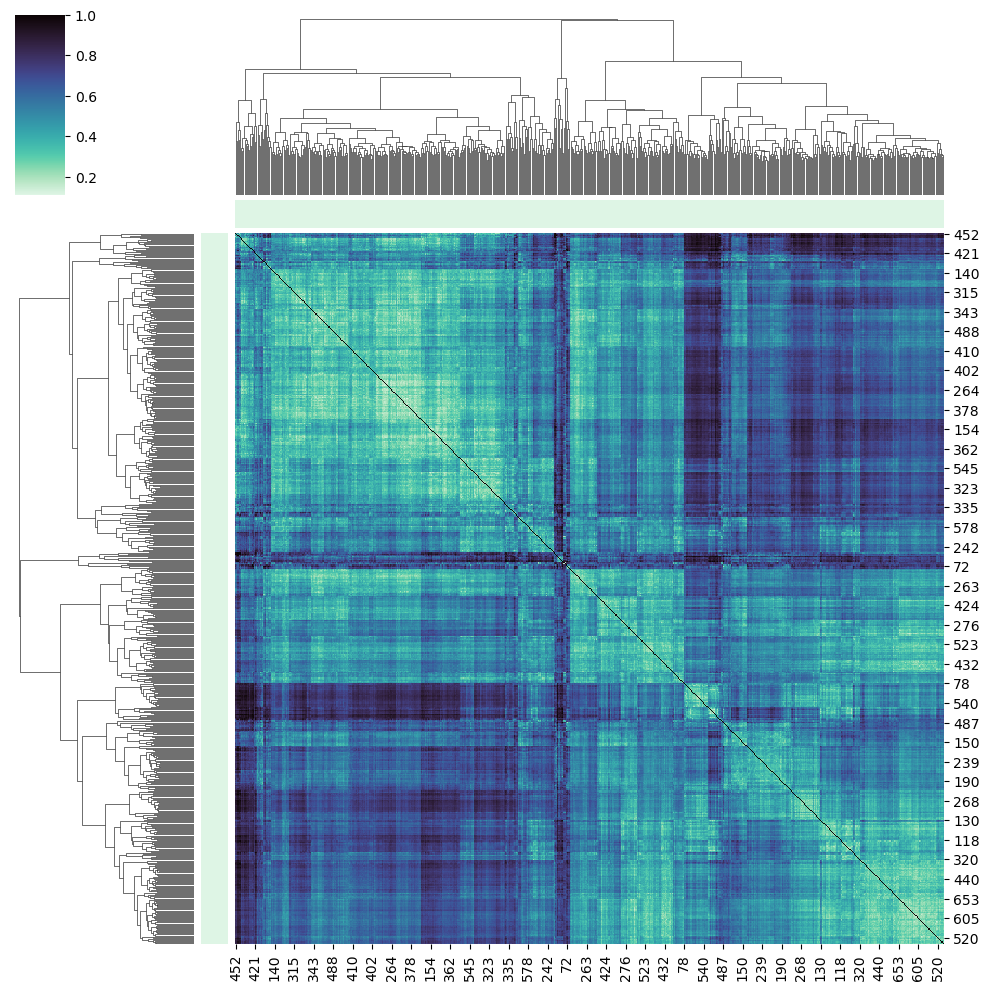

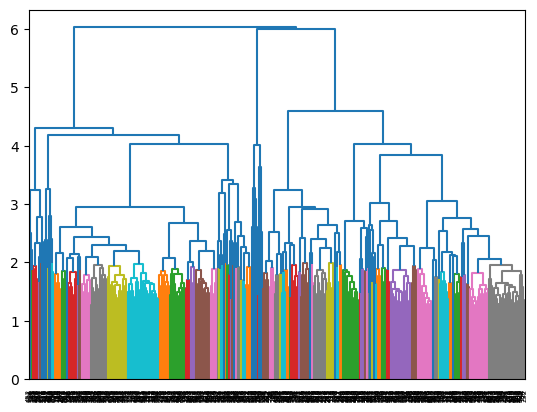

In [62]:
assert np.max(A) <= 1
dist = 1 - (A > 0) * 1. * A
save_name = os.path.join(save_path, "figures", set_name, "cluster_samples")
clusters, colors = cluster_nodes(dist, np.zeros(dist.shape), cut_dendogram=2, vmin=np.min(dist), vmax=np.max(dist), save_path=save_name)

### Dimensionality reduction and 2D visualisation

#### Variables

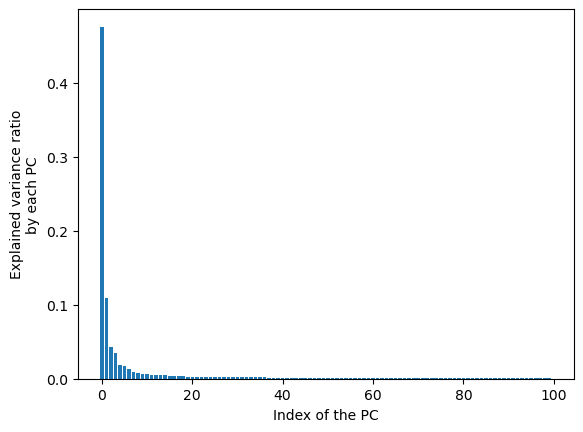

The total variance explained by the first 654 PC is 1.0.


In [63]:
_, _ = do_PCA(X.T)

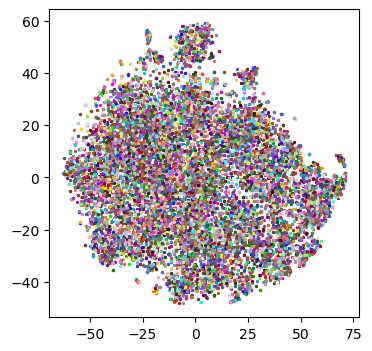

In [64]:
# T-SNE
save_name = os.path.join(save_path, "figures", set_name, "tSNE_variables")
Xr = do_TSNE(X.T, perplexity=30)
do_scatterplot_2D(Xr, np.arange(X.shape[1]).reshape(-1, 1), np.arange(X.shape[1]), xlabel=None, ylabel=None, dim1=0, dim2=1, legend=False, size=2, save_name=save_name)

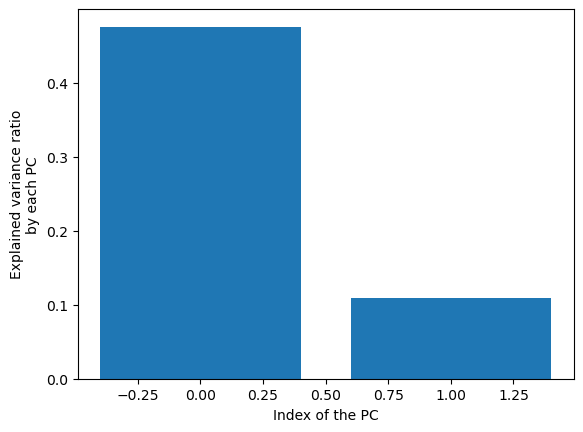

The total variance explained by the first 2 PC is 0.5899999737739563.


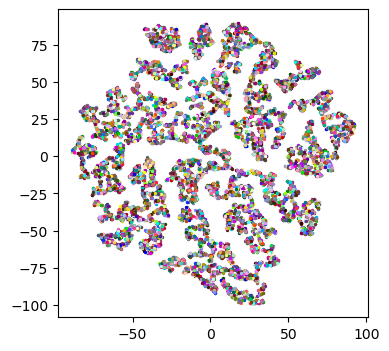

In [65]:
# PCA + T-SNE
n_dim = 2
Xt, alg = do_PCA(X.T, n_dim)
save_name = os.path.join(save_path, "figures", set_name, f"tSNE_PCA_{n_dim}_variables")
Xr = do_TSNE(Xt, perplexity=30)
do_scatterplot_2D(Xr, np.arange(X.shape[1]).reshape(-1, 1), np.arange(X.shape[1]), xlabel=None, ylabel=None, dim1=0, dim2=1, legend=False, size=2, save_name=save_name)

#### Samples

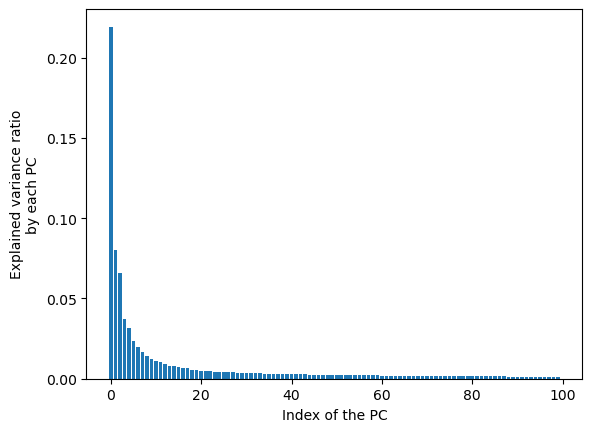

The total variance explained by the first 654 PC is 1.0.


In [66]:
_, _ = do_PCA(X)

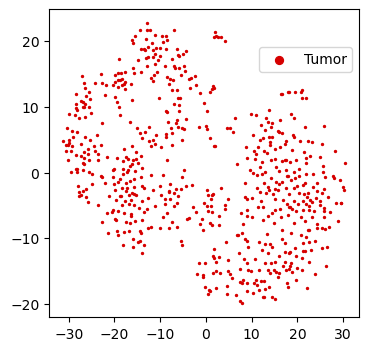

In [67]:
# T-SNE
save_name = os.path.join(save_path, "figures", set_name, "tSNE_samples")
Xr = do_TSNE(X, perplexity=30)
class_name = ["Normal", "Tumor"]
do_scatterplot_2D(Xr, y.reshape(-1, 1), class_name, xlabel=None, ylabel=None, dim1=0, dim2=1, legend=True, size=2, save_name=save_name)

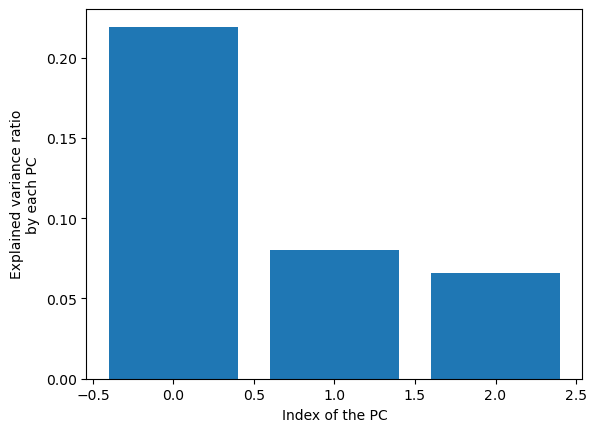

The total variance explained by the first 3 PC is 0.3700000047683716.


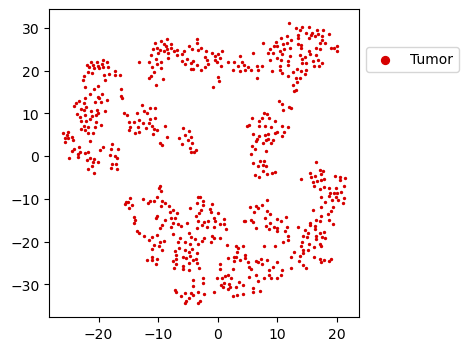

In [68]:
# PCA + T-SNE
n_dim = 3
Xt, alg = do_PCA(X, n_dim)
save_name = os.path.join(save_path, "figures", set_name, f"tSNE_PCA_{n_dim}_samples")
Xr = do_TSNE(Xt, perplexity=30)
do_scatterplot_2D(Xr, y.reshape(-1, 1), class_name, xlabel=None, ylabel=None, dim1=0, dim2=1, legend=True, size=2, save_name=save_name)

### Histograms & Boxplots

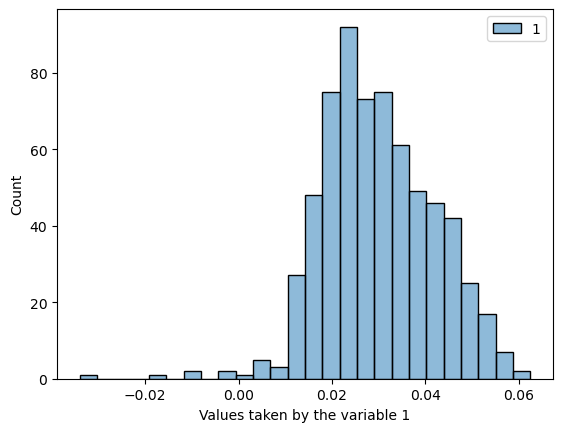

In [69]:
data = pd.DataFrame(X)
v = 1
sns.histplot(data=data, x=v, hue=y)
plt.xlabel(f"Values taken by the variable {v}")
plt.savefig(os.path.join(save_path, "figures", set_name, f"histogram_{v}_variable"), bbox_inches='tight')
plt.show()

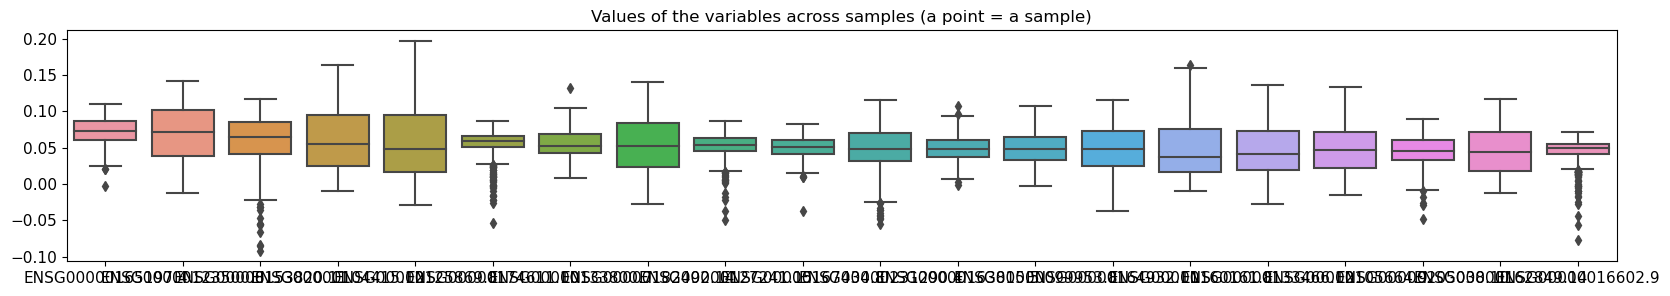

In [89]:
plot_variables_in_boxes(X, feat_name, n_feat=20, method='mean_max', save_name=os.path.join(save_path, "figures", set_name, f"boxplot_variable"))